In [145]:
import sys
import pandas as pd 
import numpy as np 
import seaborn as sns
import tensorflow.keras 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Lambda, dot, Activation, concatenate,  Layer

In [146]:
import matplotlib
from matplotlib import rc
rc('text', usetex=True)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [147]:
dfstocks = pd.read_csv('../../../data/AAPL/AAPLFinanceData2020_6.csv',parse_dates = True)
dftweets = pd.read_csv('../../../data/AAPL/stocktwits_AAPL_6_2.csv', parse_dates = True)
dftweets2 = pd.read_csv('../../../data/AAPL/twitter_AAPLclassified_2.csv', parse_dates = True)
#dftweets2 = dftweets2[dftweets2['likeCount'] >= 15]
dftweets = dftweets.replace('N/A\n', np.nan)
dftweets = dftweets.replace('N/A', np.nan)
dftweets = dftweets.replace('1\n', 1)
dftweets = dftweets.replace('0\n', 0)
dftweets = dftweets.replace('1', 1)
dftweets = dftweets.replace('0', 0)
dftweets.head()

,Unnamed: 0,symbol,message,datetime,user,message_id,sentiment,Content
0,6,AAPL,smartoptions® unusual activity alert delayed p...,2021-01-02T01:07:40Z,1712113,268974913,0.0,smartoptions unusual activity alert delayed pu...
1,7,AAPL,smartoptions® unusual activity alert delayed p...,2021-01-02T01:01:25Z,4068309,268974356,0.0,smartoptions unusual activity alert delayed pu...
2,10,AAPL,smartoptions® unusual activity alert delayed p...,2021-01-02T00:42:50Z,4068309,268972750,0.0,smartoptions unusual activity alert delayed pu...
3,11,AAPL,where the uyghur outrage from you bleeding hea...,2021-01-02T00:41:31Z,1435301,268972647,0.0,where the uyghur outrage from you bleeding hea...
4,12,AAPL,this company the biggest china supporter any c...,2021-01-02T00:35:39Z,1435301,268972098,0.0,this company the biggest china supporter any c...


In [185]:
dftweets3 = pd.read_csv('../../../data/AAPL/stocktwits_AAPL_6_2.csv', parse_dates = True)
dftweets4 = pd.read_csv('../../../data/AAPL/twitter_AAPLclassified_2.csv', parse_dates = True)
dftweets3['datetime'] = pd.to_datetime(dftweets3['datetime'])
dftweets3['datetime'] = pd.to_datetime(dftweets3['datetime'].dt.date)
dftweets3[(dftweets3['datetime']>= "2020-01-01") & (dftweets3['datetime']< "2020-12-31")]

dftweets4['datetime'] = pd.to_datetime(dftweets4['date'])
dftweets4['datetime'] = pd.to_datetime(dftweets4['datetime'].dt.date)
dftweets4 = dftweets4[(dftweets4['datetime']>= "2020-01-01") & (dftweets4['datetime']< "2020-12-31")]
print(dftweets3.shape)
print(dftweets4.shape)

(289308, 8)
(437858, 9)


In [148]:
def sentimentIndex(x):
    return np.log((1 + x[1])/ (1 + x[0]))

In [149]:
dftweets = dftweets.dropna()
dftweets['sentiment'] = dftweets['sentiment'].astype('int')
rowsdifference = dfstocks.iloc[:, 5]
dfstocks['Difference'] = rowsdifference.diff()
dfstocks['Date'] = pd.to_datetime(dfstocks['Date'])
dfstocks['Difference'].iloc[0] = 0
dftweets['datetime'] = pd.to_datetime(dftweets['datetime'])
dftweets['datetime'] = pd.to_datetime(dftweets['datetime'].dt.date)
dftweets = dftweets[(dftweets['datetime']>= "2020-01-01") & (dftweets['datetime']< "2020-12-31")]
dftweets = dftweets.pivot_table(index='datetime',columns='sentiment', aggfunc='size')
print(dftweets[1])
dftweets['sentimentIndex'] = dftweets.apply(sentimentIndex, axis = 1)

dftweets.sort_values('datetime', inplace=True, ascending=True)

dftweets2['sentiment'] = dftweets2['sentiment'].astype('int')
dftweets2['datetime'] = pd.to_datetime(dftweets2['date'])
dftweets2['datetime'] = pd.to_datetime(dftweets2['datetime'].dt.date)
dftweets2 = dftweets2[(dftweets2['datetime']>= "2020-01-01") & (dftweets2['datetime']< "2020-12-31")]
dftweets2 = dftweets2.pivot_table(index='datetime',columns='sentiment', aggfunc='size')
dftweets2['sentimentIndex'] = dftweets2.apply(sentimentIndex, axis = 1)

dftweets3 = pd.concat([dftweets, dftweets2])
dftweets3 = dftweets3.groupby('datetime').transform('sum') 
dftweets3['sentimentIndex'] = dftweets3.apply(sentimentIndex, axis = 1)

merged = pd.merge(left=dftweets3, left_on='datetime',
         right=dfstocks, right_on='Date')
merged = merged.drop_duplicates('Date')
merged_sim  = merged[ ['Open', 'High', 'Low', 'Adj Close', 'Volume','sentimentIndex','Close']]

merged.shape

datetime
2020-01-01     70
2020-01-02    613
2020-01-03    595
2020-01-04     78
2020-01-05     89
             ... 
2020-12-26     34
2020-12-27     53
2020-12-28    313
2020-12-29    323
2020-12-30    272
Name: 1, Length: 365, dtype: int64


(252, 11)

In [150]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


## SAA LSTM

In [151]:
n_days = 1
n_features = 7
dataset = merged_sim.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset = series_to_supervised(dataset, n_days,1)

droplist = []
for i in range(n_features*n_days, n_features*n_days + 6):
    droplist.append(i)
print(droplist)
dataset.drop(dataset.columns[droplist], axis = 1, inplace = True)
dataset

[7, 8, 9, 10, 11, 12]


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var7(t)
1,0.210292,0.220719,0.254288,0.231024,0.276337,0.636414,0.235677,0.226620
2,0.213100,0.220658,0.258322,0.222082,0.303263,0.365462,0.226620,0.233971
3,0.202734,0.218760,0.246774,0.229339,0.233888,0.643030,0.233971,0.229598
4,0.221399,0.221637,0.261340,0.225022,0.210259,0.543033,0.229598,0.244486
5,0.213131,0.232474,0.260354,0.239720,0.267891,0.562431,0.244486,0.264462
...,...,...,...,...,...,...,...,...
247,0.920523,0.946366,0.942232,0.940578,0.359342,0.861056,0.940321,0.928906
248,0.927311,0.922121,0.956151,0.929212,0.158981,0.740455,0.928906,0.941437
249,0.916944,0.934734,0.960092,0.941689,0.076301,1.000000,0.941437,1.000000
250,0.949895,0.982245,0.989777,1.000000,0.249034,0.920926,1.000000,0.977419


In [152]:
train_size = int(merged.shape[0]*0.67)

n_obs = n_days * n_features
values = dataset.values
train, test =  values[0:train_size, :], values[train_size:len(values), :]
train_X, train_y = train[:,:n_obs], train[:,-1]
test_X, test_y = test[:,:n_obs], test[:,-1]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))

In [153]:
batch_size = 32
time_steps = 1
input_dim = (train_X.shape[1], train_X.shape[2])
#np.random.seed(420)
epochs = 50

In [154]:
#https://github.com/philipperemy/keras-attention-mechanism
class Attention(Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def __call__(self, hidden_states):
        hidden_size = int(hidden_states.shape[2])
        score_first_part = Dense(hidden_size, use_bias=False, name='attention_score_vec')(hidden_states)
        h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_states)
        score = dot([score_first_part, h_t], [2, 1], name='attention_score')
        attention_weights = Activation('softmax', name='attention_weight')(score)
        context_vector = dot([hidden_states, attention_weights], [1, 1], name='context_vector')
        pre_activation = concatenate([context_vector, h_t], name='attention_output')
        attention_vector = Dense(128, use_bias=False, activation='tanh', name='attention_vector')(pre_activation)
        return attention_vector

Epoch 1/50
6/6 [==============================] - 2s 85ms/step - loss: 0.0943 - accuracy: 0.0119 - val_loss: 0.0120 - val_accuracy: 0.0120
Epoch 2/50
6/6 [==============================] - 0s 57ms/step - loss: 0.0095 - accuracy: 0.0037 - val_loss: 0.0282 - val_accuracy: 0.0120
Epoch 3/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0133 - accuracy: 0.0052 - val_loss: 0.0079 - val_accuracy: 0.0120
Epoch 4/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0042 - accuracy: 0.0037 - val_loss: 0.0131 - val_accuracy: 0.0120
Epoch 5/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0033 - accuracy: 0.0026 - val_loss: 0.0041 - val_accuracy: 0.0120
Epoch 6/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 0.0119 - val_loss: 0.0062 - val_accuracy: 0.0120
Epoch 7/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0014 - accuracy: 0.0074 - val_loss: 0.0019 - val_accuracy: 0.0120
Epoch 8/50
6/6 [===========

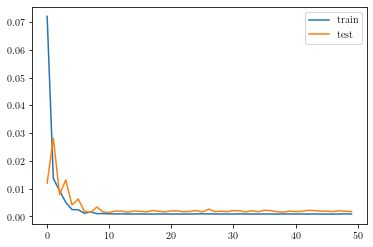

In [155]:
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences = True))
model.add(Attention())
model.add(Dense(1, activation = 'relu'))


model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_X, train_y,
                validation_data = (test_X, test_y),
                batch_size=batch_size,
                epochs=epochs)
            
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

In [156]:
#model.save('../../models/SAA_LSTM.h5')

In [157]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, (-1 * n_features + 1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [158]:
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, (-1 * n_features + 1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [159]:
inv_yhat

array([136.34276 , 135.59723 , 126.01874 , 121.5394  , 116.72142 ,
       119.681946, 118.09504 , 114.90154 , 117.15859 , 118.56937 ,
       115.70027 , 112.54526 , 110.11728 , 109.88713 , 113.73887 ,
       110.89629 , 109.71459 , 112.99846 , 116.850975, 116.64451 ,
       117.728424, 119.25733 , 115.71194 , 117.87527 , 116.253746,
       117.24064 , 117.72912 , 118.656105, 125.420555, 124.8774  ,
       123.83549 , 122.531876, 122.371544, 119.90392 , 119.6867  ,
       119.59078 , 118.540634, 117.79685 , 117.19491 , 118.58445 ,
       114.87573 , 117.042076, 111.79212 , 111.10312 , 112.37701 ,
       116.69444 , 120.97766 , 120.72381 , 120.62963 , 118.372444,
       121.09176 , 122.061264, 121.734055, 122.36282 , 122.30783 ,
       121.13129 , 120.84416 , 120.366264, 117.54682 , 116.962715,
       118.3605  , 119.12639 , 121.20989 , 124.673584, 125.18812 ,
       125.74775 , 124.92692 , 126.11863 , 126.98737 , 125.58703 ,
       125.12235 , 124.74149 , 124.87033 , 129.45113 , 130.561

### SA LSTM

In [160]:
n_days = 1
n_features = 7
dataset = merged_sim.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset = series_to_supervised(dataset, n_days,1)

droplist = []
for i in range(n_features*n_days, n_features*n_days + 6):
    droplist.append(i)
print(droplist)
dataset.drop(dataset.columns[droplist], axis = 1, inplace = True)
dataset

[7, 8, 9, 10, 11, 12]


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var7(t)
1,0.210292,0.220719,0.254288,0.231024,0.276337,0.636414,0.235677,0.226620
2,0.213100,0.220658,0.258322,0.222082,0.303263,0.365462,0.226620,0.233971
3,0.202734,0.218760,0.246774,0.229339,0.233888,0.643030,0.233971,0.229598
4,0.221399,0.221637,0.261340,0.225022,0.210259,0.543033,0.229598,0.244486
5,0.213131,0.232474,0.260354,0.239720,0.267891,0.562431,0.244486,0.264462
...,...,...,...,...,...,...,...,...
247,0.920523,0.946366,0.942232,0.940578,0.359342,0.861056,0.940321,0.928906
248,0.927311,0.922121,0.956151,0.929212,0.158981,0.740455,0.928906,0.941437
249,0.916944,0.934734,0.960092,0.941689,0.076301,1.000000,0.941437,1.000000
250,0.949895,0.982245,0.989777,1.000000,0.249034,0.920926,1.000000,0.977419


In [161]:
train_size = int(merged.shape[0]*0.67)

n_obs = n_days * n_features
values = dataset.values
train, test =  values[0:train_size, :], values[train_size:len(values), :]
train_X, train_y = train[:,:n_obs], train[:,-1]
test_X, test_y = test[:,:n_obs], test[:,-1]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))

Epoch 1/50
6/6 [==============================] - 2s 79ms/step - loss: 0.1158 - accuracy: 0.0026 - val_loss: 0.3476 - val_accuracy: 0.0000e+00
Epoch 2/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0790 - accuracy: 0.0052 - val_loss: 0.1960 - val_accuracy: 0.0000e+00
Epoch 3/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0297 - accuracy: 0.0026 - val_loss: 0.0915 - val_accuracy: 0.0120
Epoch 4/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0165 - accuracy: 0.0052 - val_loss: 0.0317 - val_accuracy: 0.0120
Epoch 5/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0093 - accuracy: 0.0052 - val_loss: 0.0090 - val_accuracy: 0.0120
Epoch 6/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0093 - accuracy: 0.0052 - val_loss: 0.0041 - val_accuracy: 0.0120
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0081 - accuracy: 0.0052 - val_loss: 0.0044 - val_accuracy: 0.0120
Epoch 8/50
6/6 [===

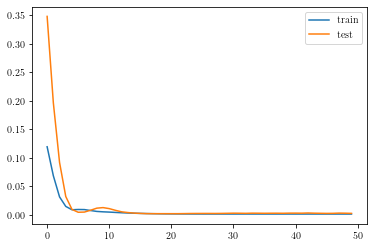

In [162]:
modelSA = Sequential()
modelSA.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2])))
#modelSA.add(Attention())
modelSA.add(Dense(1, activation = 'relu'))


modelSA.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

history = modelSA.fit(train_X, train_y,
                validation_data = (test_X, test_y),
                batch_size=batch_size,
                epochs=epochs)
            
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

In [163]:
yhatSA = modelSA.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhatSA = np.concatenate((yhatSA, test_X[:, (-1 * n_features + 1):]), axis=1)
inv_yhatSA = scaler.inverse_transform(inv_yhatSA)
inv_yhatSA = inv_yhatSA[:,0]

In [164]:
#modelSA.save("F:/ASDRP/models/AAPL/S_LSTM.h5")

## Regular LSTM Baseline

In [165]:
merged_simbase  = merged_sim[ ['Open', 'High', 'Low', 'Adj Close', 'Volume','Close']]
n_days = 1
n_features = 6
dataset = merged_simbase.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset = series_to_supervised(dataset, n_days,1)

droplist = []
for i in range(n_features*n_days, n_features*n_days + 5):
    droplist.append(i)
print(droplist)
dataset.drop(dataset.columns[droplist], axis = 1, inplace = True)
dataset

[6, 7, 8, 9, 10]


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var6(t)
1,0.210292,0.220719,0.254288,0.231024,0.276337,0.235677,0.226620
2,0.213100,0.220658,0.258322,0.222082,0.303263,0.226620,0.233971
3,0.202734,0.218760,0.246774,0.229339,0.233888,0.233971,0.229598
4,0.221399,0.221637,0.261340,0.225022,0.210259,0.229598,0.244486
5,0.213131,0.232474,0.260354,0.239720,0.267891,0.244486,0.264462
...,...,...,...,...,...,...,...
247,0.920523,0.946366,0.942232,0.940578,0.359342,0.940321,0.928906
248,0.927311,0.922121,0.956151,0.929212,0.158981,0.928906,0.941437
249,0.916944,0.934734,0.960092,0.941689,0.076301,0.941437,1.000000
250,0.949895,0.982245,0.989777,1.000000,0.249034,1.000000,0.977419


In [166]:
train_size = int(merged.shape[0]*0.67)

n_obs = n_days * n_features
values = dataset.values
train, test =  values[0:train_size, :], values[train_size:len(values), :]
train_X, train_y = train[:,:n_obs], train[:,-1]
test_X, test_y = test[:,:n_obs], test[:,-1]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))

In [167]:
batch_size = 32
epochs = 50

In [168]:
modelbase = Sequential()
modelbase.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2])))
modelbase.add(Dense(1, activation = 'relu'))
modelbase.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

history = modelbase.fit(train_X, train_y,
                validation_data = (test_X, test_y),
                batch_size=batch_size,
                epochs=epochs)
# plt.plot(history.history['loss'], label = 'train')
# plt.plot(history.history['val_loss'], label = 'test')
# plt.legend()
# plt.show()

Epoch 1/50
6/6 [==============================] - 2s 80ms/step - loss: 0.1495 - accuracy: 0.0074 - val_loss: 0.4080 - val_accuracy: 0.0000e+00
Epoch 2/50
6/6 [==============================] - 0s 11ms/step - loss: 0.1109 - accuracy: 0.0052 - val_loss: 0.2677 - val_accuracy: 0.0000e+00
Epoch 3/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0500 - accuracy: 0.0052 - val_loss: 0.1570 - val_accuracy: 0.0000e+00
Epoch 4/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0289 - accuracy: 0.0052 - val_loss: 0.0755 - val_accuracy: 0.0120
Epoch 5/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0122 - accuracy: 0.0026 - val_loss: 0.0258 - val_accuracy: 0.0120
Epoch 6/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0072 - accuracy: 0.0052 - val_loss: 0.0068 - val_accuracy: 0.0120
Epoch 7/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0077 - accuracy: 0.0026 - val_loss: 0.0030 - val_accuracy: 0.0120
Epoch 8/50
6/6 

In [169]:
yhatbase = modelbase.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
inv_yhatbase = np.concatenate((yhatbase, test_X[:, (-1 * n_features + 1):]), axis=1)
inv_yhatbase = scaler.inverse_transform(inv_yhatbase)
inv_yhatbase = inv_yhatbase[:,0]

In [170]:
#modelbase.save('../../models/LSTMBASE.h5')

In [171]:
inv_yhatbase

array([138.68018 , 138.28232 , 127.08233 , 121.84123 , 116.53018 ,
       120.13678 , 118.75834 , 115.08625 , 117.54072 , 119.10973 ,
       116.01011 , 112.331894, 109.640114, 109.294266, 113.8769  ,
       110.99    , 109.17495 , 112.80753 , 117.303986, 117.10285 ,
       117.9867  , 119.99754 , 115.81259 , 118.28794 , 116.62836 ,
       117.74558 , 118.38933 , 119.21713 , 126.058495, 125.83532 ,
       124.68547 , 123.30211 , 123.35011 , 120.68477 , 120.18468 ,
       120.230515, 119.307335, 118.415726, 117.47235 , 119.09357 ,
       115.257034, 117.03489 , 111.67177 , 111.07394 , 112.46396 ,
       117.05591 , 121.69318 , 121.44661 , 121.33763 , 118.7124  ,
       121.71476 , 122.8588  , 122.54886 , 123.22073 , 123.113335,
       121.87395 , 121.48536 , 121.19146 , 118.08515 , 117.33159 ,
       118.974655, 119.9289  , 121.67173 , 125.6833  , 126.360466,
       127.06427 , 126.17709 , 127.31446 , 128.38187 , 126.86999 ,
       126.02831 , 125.94476 , 126.06877 , 130.70755 , 132.205

## Evaluation Metrics

In [172]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import r2_score 

#FOR SAA_LSTM
print("=====SAA LSTM=====")
rmseSAA = np.sqrt(mean_squared_error(inv_y, inv_yhat))
maeSAA = mean_absolute_error(inv_y,inv_yhat)
r2SAA = r2_score(inv_y, inv_yhat)


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mapeSAA = mean_absolute_percentage_error(inv_y,inv_yhat)



print("RMSE: " , rmseSAA)
print("MAE: ", maeSAA)
print("R2: ", r2SAA)
print("MAPE: ", mapeSAA)

#FOR SA_LSTM
print("=====SA LSTM=====")
rmseSA = np.sqrt(mean_squared_error(inv_y, inv_yhatSA))
maeSA = mean_absolute_error(inv_y,inv_yhatSA)
r2SA = r2_score(inv_y, inv_yhatSA)


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mapeSA = mean_absolute_percentage_error(inv_y,inv_yhatSA)



print("RMSE: " , rmseSA)
print("MAE: ", maeSA)
print("R2: ", r2SA)
print("MAPE: ", mapeSA)

#FOR BASE LSTM
rmsebase = np.sqrt(mean_squared_error(inv_y, inv_yhatbase))
maebase = mean_absolute_error(inv_y,inv_yhatbase)
r2base = r2_score(inv_y, inv_yhatbase)


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mapebase = mean_absolute_percentage_error(inv_y,inv_yhatbase)


print("=====BASE LSTM=====")
print("RMSE: " , rmsebase)
print("MAE: ", maebase)
print("R2: ", r2base)
print("MAPE: ", mapebase)

=====SAA LSTM=====
RMSE:  3.3638203
MAE:  2.5952487
R2:  0.7367108534666233
MAPE:  2.183898165822029
=====SA LSTM=====
RMSE:  3.705107
MAE:  2.8847516
R2:  0.6805750381542257
MAPE:  2.4158531799912453
=====BASE LSTM=====
RMSE:  3.961425
MAE:  3.1680863
R2:  0.6348509273669605
MAPE:  2.6501141488552094


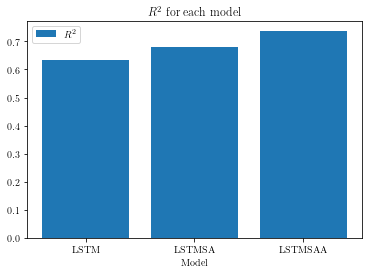

In [173]:
# R2 
x = ["LSTM", "LSTMSA", "LSTMSAA"]
y = [r2base, r2SA, r2SAA]
plt.xlabel("Model")
plt.bar(x,y, label = r'$R^2$')
plt.title(r'$R^2$ for each model')
plt.legend()


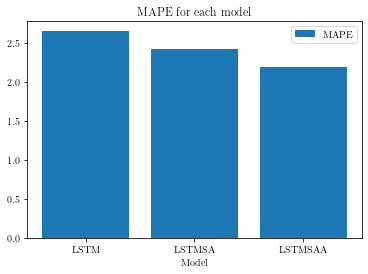

In [174]:
#MAPE
x = ["LSTM", "LSTMSA", "LSTMSAA"]
y = [mapebase, mapeSA, mapeSAA]
plt.xlabel("Model")
plt.bar(x,y, label = r'MAPE')
plt.title(r'MAPE for each model')
plt.legend()

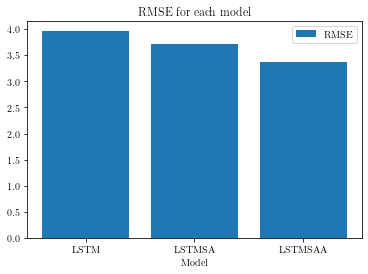

In [175]:
#RMSE
x = ["LSTM", "LSTMSA", "LSTMSAA"]
y = [rmsebase, rmseSA, rmseSAA]
plt.xlabel("Model")
plt.bar(x,y, label = r'RMSE')
plt.title(r'RMSE for each model')
plt.legend()

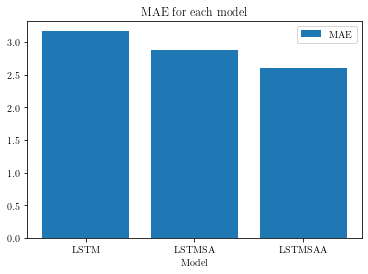

In [176]:
#MAE
x = ["LSTM", "LSTMSA", "LSTMSAA"]
y = [maebase, maeSA, maeSAA]
plt.xlabel("Model")
plt.bar(x,y, label = r'MAE')
plt.title(r'MAE for each model')
plt.legend()

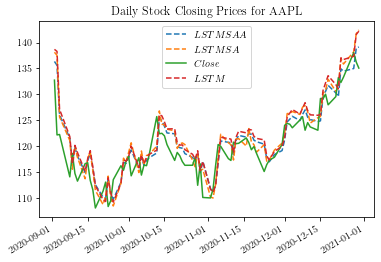

In [186]:
x = merged['Date'][train_size+1:]
si = merged['sentimentIndex'][train_size:]
#plt.plot(merged['Date'][0:train_size], history, label = "History")
fig, ax = plt.subplots()
plt.plot(x,inv_yhat, label = r'$LSTMSAA$', ls = '--')
plt.plot(x,inv_yhatSA, label = r'$LSTMSA$', ls = '--')
plt.plot(x,inv_y, label = r'$Close$')
plt.plot(x,inv_yhatbase,label = r'$LSTM$', ls = '--')
plt.title("Daily Stock Closing Prices for AAPL")
fig.autofmt_xdate()
#plt.plot(x, merged['Close'][train_size:len(merged)-2], label = "Close")
plt.legend()


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2522  , p=0.2642  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2674  , p=0.2603  , df=1
likelihood ratio test: chi2=1.2642  , p=0.2609  , df=1
parameter F test:         F=1.2522  , p=0.2642  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8137  , p=0.4444  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.6608  , p=0.4359  , df=2
likelihood ratio test: chi2=1.6553  , p=0.4371  , df=2
parameter F test:         F=0.8137  , p=0.4444  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6454  , p=0.5866  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.9923  , p=0.5740  , df=3
likelihood ratio test: chi2=1.9843  , p=0.5757  , df=3
parameter F test:         F=0.6454  , p=0.5866  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5268  , p=0.7161  

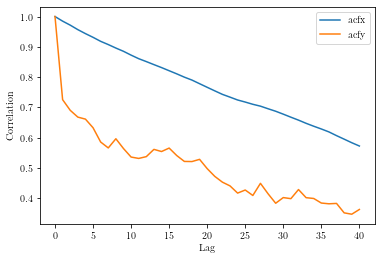

In [192]:
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf, grangercausalitytests
#1 gives highest granger causality
rowsdiff2 = merged['sentimentIndex']
rowsdiff2 = rowsdiff2.diff()
merged['Differencetweets'] = rowsdiff2
merged['Differencetweets'].iloc[0] = 0
res = grangercausalitytests(merged[['Difference','Differencetweets']][1:], maxlag=15)
acfx= acf(merged[['Close']])
pacfx = pacf(merged[['Close']])
acfy = acf(merged[['sentimentIndex']])
pacfy = pacf(merged[['sentimentIndex']])
plt.plot(acfx, label = "Stock Prices")
#plt.plot(pacfx, label = "pacfx")
plt.plot(acfy, label = "Sentiment Indexes")
#plt.plot(pacfy, label = "pacfy")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.title("Auto-correlation function of Stock Prices and Sentiment Indexes")
plt.legend()

In [179]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(merged['Differencetweets'][1:])

Results of Dickey-Fuller Test:
Test Statistic                -1.200374e+01
p-value                        3.300499e-22
#Lags Used                     3.000000e+00
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64


In [180]:
dfstocks

,Date,Open,High,Low,Close,Adj Close,Volume,Difference
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,74.444603,135480400,0.000000
1,2020-01-03,74.287498,75.144997,74.125000,74.357498,73.720840,146322800,-0.723763
2,2020-01-06,73.447502,74.989998,73.187500,74.949997,74.308266,118387200,0.587425
3,2020-01-07,74.959999,75.224998,74.370003,74.597504,73.958794,108872000,-0.349472
4,2020-01-08,74.290001,76.110001,74.290001,75.797501,75.148521,132079200,1.189728
...,...,...,...,...,...,...,...,...
248,2020-12-24,131.320007,133.460007,131.100006,131.970001,131.970001,54930100,1.009995
249,2020-12-28,133.990005,137.339996,133.509995,136.690002,136.690002,124486200,4.720001
250,2020-12-29,138.050003,138.789993,134.339996,134.869995,134.869995,121047300,-1.820007
251,2020-12-30,135.580002,135.990005,133.399994,133.720001,133.720001,96452100,-1.149994
